# INF421 — Path Planning Algorithms — Groupe  


**Membres**  

- KAMDEM POUOKAM Ivann Harold — **PC**  

-  — **PC**


### Installation du projet

In [199]:
!pip install uv


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [200]:
# We install the project if not already installed
import os

if not os.path.exists("src/random_explorer"):
    !uv pip install git+https://www.github.com/KpihX/random-explorer.git
else:
    !uv pip install .

Resolved 56 packages in 19ms                                         
   Building random-explorer @ file:///home/kpihx/Work/X/random-explorer
      Built random-explorer @ file:///home/kpihx/Work/X/random-explorer
Prepared 1 package in 10ms                                               
Uninstalled 1 package in 1ms
Installed 1 package in 4ms1.0 (from file:///home/kpihx/Work/
 ~ random-explorer==0.1.0 (from file:///home/kpihx/Work/X/random-explorer)


In [201]:
# We load environment variables

!uv pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

Audited 1 package in 1ms


True

In [202]:
# We load kaggle credentials (case where the notebook runs on Colab)

try:
    from google.colab import userdata
    os.environ["KAGGLE_API_TOKEN"] = userdata.get('KAGGLE_API_TOKEN')
except:
   pass

### Chargement des données

In [203]:
import kagglehub

file = "scenario4.txt"

file_path = kagglehub.dataset_download(
    handle="ivannkamdem/random-explorer",
    path=file,
)

print(f"File path: {file_path}")

File path: /home/kpihx/.cache/kagglehub/datasets/ivannkamdem/random-explorer/versions/1/scenario4.txt


### Question 1

In [204]:
from random_explorer import Environment

env = Environment(file_path)

╭────────────────────────────────────────────────── Environment ──────────────────────────────────────────────────╮
│ Environment initialized successfully with valid datas                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Question 2

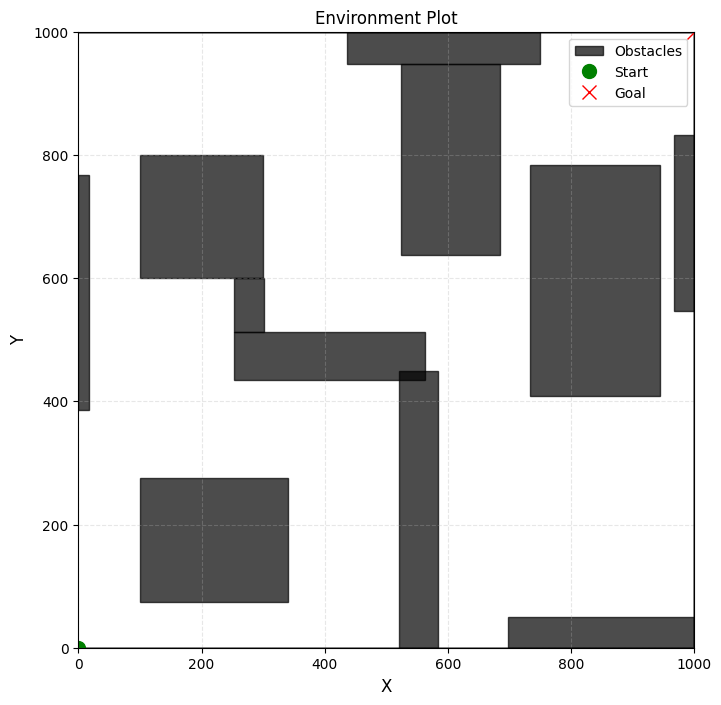

In [205]:
_, ax = env.plot_environment()

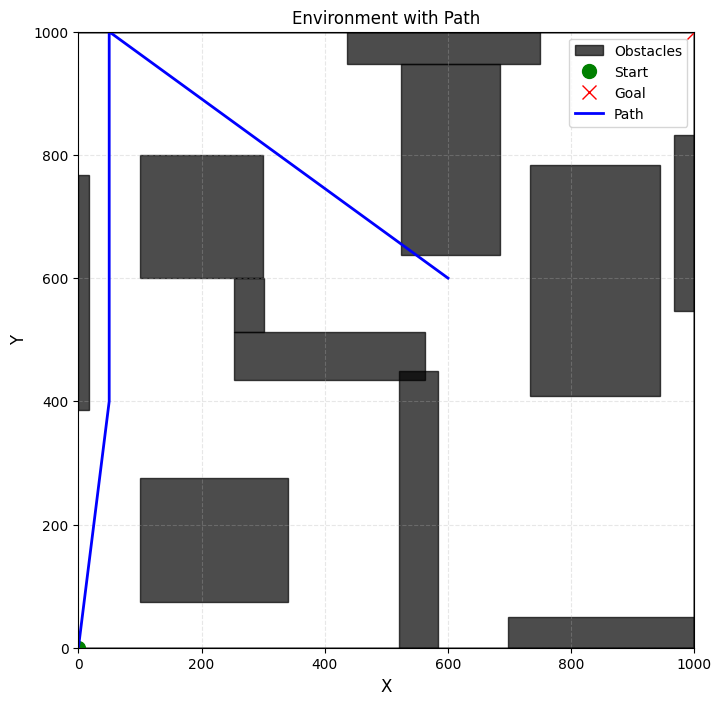

In [206]:
path = ((0, 0), (50, 400), (50, 1000), (600, 600))
_, ax = env.plot_environment(path=path, title="Environment with Path")

### Question 3 : Définition des particules, fonction de fitness et structure de données**

**1. Définition d'une particule**

Dans le contexte de la planification de trajectoire, le robot doit aller d'un point de départ $u_s$ à un point d'arrivée $u_d$.
Une particule ne représente pas la position du robot à un instant $t$, mais **un chemin complet candidat**.

Nous modélisons un chemin par une suite ordonnée de $N$ points de passage (waypoints) intermédiaires : $w_1, w_2, ..., w_N$.
Le chemin complet est donc la ligne brisée : $u_s \rightarrow w_1 \rightarrow w_2 \rightarrow ... \rightarrow w_N \rightarrow u_d$.

Chaque waypoint $w_j$ ayant 2 coordonnées $(x, y)$, une particule $i$ est un vecteur de dimension $2N$ :
$$ x_i = [x_{i,1}, y_{i,1}, x_{i,2}, y_{i,2}, ..., x_{i,N}, y_{i,N}] $$

**2. Fonction de Fitness (Coût)**

L'objectif est de minimiser la fonction objectif $f(x)$. Celle-ci doit prendre en compte deux critères :
1.  **La longueur du chemin :** C'est la somme des distances euclidiennes entre les points successifs.
2.  **La validité (évitement d'obstacles) :** Le chemin ne doit pas traverser d'obstacles.

Nous utilisons une méthode de pénalité. Si le chemin est en collision, on lui ajoute un coût prohibitif pour que l'algorithme le rejette naturellement au profit des chemins valides.
$$ f(x_i) = \text{Longueur}(x_i) + \text{Pénalité}(x_i) $$

*   $\text{Longueur}(x_i) = \|w_1 - u_s\| + \sum_{j=1}^{N-1} \|w_{j+1} - w_j\| + \|u_d - w_N\|$
*   $\text{Pénalité}(x_i) = 0$ si le chemin est libre, sinon une grande valeur.

*Remarque : Pour aider la convergence, on peut aussi ajouter la longueur à la pénalité même en cas de collision, pour que l'algorithme préfère un chemin "invalide court" (qui traverse juste un coin) à un chemin "invalide long".*

**3. Structure de données**
Pour optimiser les calculs (vectorisation), nous utiliserons des tableaux multi-dimensionnels via la bibliothèque `numpy` de Python.

Si $S$ est le nombre de particules et $N$ le nombre de waypoints :
*   **Positions $X$ :** Matrice de taille $(S, N, 2)$.
*   **Vitesses $V$ :** Matrice de taille $(S, N, 2)$.
*   **Meilleurs Locaux $P$ (p_best) :** Matrice de taille $(S, N, 2)$.
*   **Scores Locaux :** Vecteur de taille $(S)$.
*   **Meilleur Global $G$ (g_best) :** Matrice de taille $(N, 2)$.

### Question 4 : Méthode de détection de collision pour un chemin

La classe `Environment` vérifie si un *point* est en collision. Or, un chemin est une suite de *segments*. Il est possible que les extrémités d'un segment soient valides (hors obstacle), mais que le segment traverse un obstacle entre les deux.

**Méthode proposée : L'Échantillonnage (Sampling)**
Pour vérifier un segment $[A, B]$ :
1.  Calculer la distance euclidienne $d = \|B - A\|$.
2.  Définir un pas de discrétisation $\epsilon$ (par exemple, 10 unités ou 1% de la taille du monde).
3.  Générer des points intermédiaires le long du vecteur $\vec{AB}$ :
    $$ P_k = A + k \cdot \epsilon \cdot \frac{\vec{AB}}{\|\vec{AB}\|} $$
4.  Pour chaque point $P_k$, vérifier `env.is_collision(P_k)`.
5.  Si un seul point touche un obstacle, le segment est invalide.

Le chemin complet est valide si et seulement si tous ses segments successifs sont valides.

### Question 5 : Pseudo-code de l'algorithme PSO

Voici la logique de l'algorithme adapté à notre problème :

```text
Algorithme PSO_PathPlanning
Entrées : Environment, N (nombre waypoints), S (nombre particules), Max_Iter
Hyper-paramètres : w (inertie), c1 (cognitif), c2 (social)

// Initialisation
Pour chaque particule i de 1 à S :
    X[i] = N points aléatoires dans l'environnement
    V[i] = 0
    P_best[i] = X[i]
    Score_P[i] = Evaluate_Fitness(X[i])
   
G_best = P_best avec le score minimal
Score_G = min(Score_P)

// Itérations
Pour k de 1 à Max_Iter :
    Pour chaque particule i de 1 à S :
        // Mise à jour Vitesse et Position
        r1, r2 = nombres aléatoires uniformes [0, 1]
        V[i] = w*V[i] + c1*r1*(P_best[i] - X[i]) + c2*r2*(G_best - X[i])
        X[i] = X[i] + V[i]
           
        // On garde les points dans les limites du monde [0, xmax] * [0, ymax]
        X[i] = Clip(X[i], min_x=0, max_x=x_max, min_y=0, max_y=y_max)
           
        // b. Évaluation
        Score_Actuel = Evaluate_Fitness(X[i])
           
        // c. Mise à jour des mémoires
        Si Score_Actuel < Score_P[i] :
            P_best[i] = X[i]
            Score_P[i] = Score_Actuel
               
            Si Score_Actuel < Score_G :
                G_best = X[i]
                Score_G = Score_Actuel

// Reconstruction et Retour
Chemin_Final = [Start] + G_best + [Goal]
Retourner Chemin_Final
```

### Question 6 : Analyse de complexité

Soient les paramètres suivants :
*   $K$ : Nombre d'itérations (`Max_Iter`).
*   $S$ : Nombre de particules.
*   $N$ : Nombre de waypoints par chemin.
*   $M$ : Nombre d'obstacles dans l'environnement.
*   $D$ : Longueur moyenne d'un segment divisée par le pas d'échantillonnage $\epsilon$ (nombre de tests de collision par segment).

**Coût d'une itération :**
1.  **Mise à jour (Vitesse/Position) :** Opérations matricielles simples sur $S \times N$ points $\rightarrow O(S \cdot N)$.
2.  **Évaluation de la Fitness (Le goulot d'étranglement) :**
    *   Chaque particule a $N+1$ segments (du départ à l'arrivée).
    *   Chaque segment necessite le calcul de sa longueur : O(1)
    *   Chaque segment nécessite $D$ vérifications de points.
    *   Chaque vérification de point teste $M$ obstacles.
    *   Coût par particule : $O(N \cdot D \cdot M) + O(N) = O(N \cdot D \cdot M)$.
    *   Coût pour $S$ particules : $O(S \cdot N \cdot D \cdot M)$.

**Complexité Totale :**
$$ O(K \cdot S \cdot N \cdot D \cdot M) $$

**Remarque :** 

Cette complexité est linéaire par rapport aux itérations et aux particules, mais dépend fortement de la précision de la détection de collision ($D$) et du nombre d'obstacles ($M$).

Dans le pire des cas, $D = L / eps$ où $L = max(x_{max}, y_{max})$ (cas qui peut se produire en cas de chemins en zigzag).

### Question 7 : Implémentation

In [215]:
from random_explorer import PSOPathPlanner

S = 100 # Number of particles
N = 7 # Number of waypoints
w = 0.6  # Inertia weight
c1 = 1.4 # Cognitive coefficient
c2 = 1.4 # Social coefficient
max_iter = 1000  # Maximum number of iterations
pso_planner = PSOPathPlanner(env, num_particles=S, num_waypoints=N, max_iter=max_iter, w=w, c1=c1, c2=c2)


final_path, final_score, history = pso_planner.solve(soft_mode=True, penalty_weight=1000, base_penalty=100.0)

In [216]:
from random_explorer import Console

console = Console()
console.display(f"Final score: {final_score}\nFinal path: \n{final_path}", title="PSO Path Planning", border_style="green")

╭─────────────────────────────────────────────── PSO Path Planning ───────────────────────────────────────────────╮
│ Final score: 64822.524205832546                                                                                 │
│ Final path:                                                                                                     │
│ [[   0.            0.        ]                                                                                  │
│  [ 584.            5.26827406]                                                                                  │
│  [ 602.47971626  101.72652313]                                                                                  │
│  [ 608.19158772  131.54066364]                                                                                  │
│  [ 733.          783.        ]                                                                                  │
│  [ 953.07496161  961.86249692]                                                                                  │
│  [ 989.70266288  991.63102429]                                                                                  │
│  [1000.         1000.        ]                                                                                  │
│  [1000.         1000.        ]]                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Final Path Found by PSO'}, xlabel='X', ylabel='Y'>)

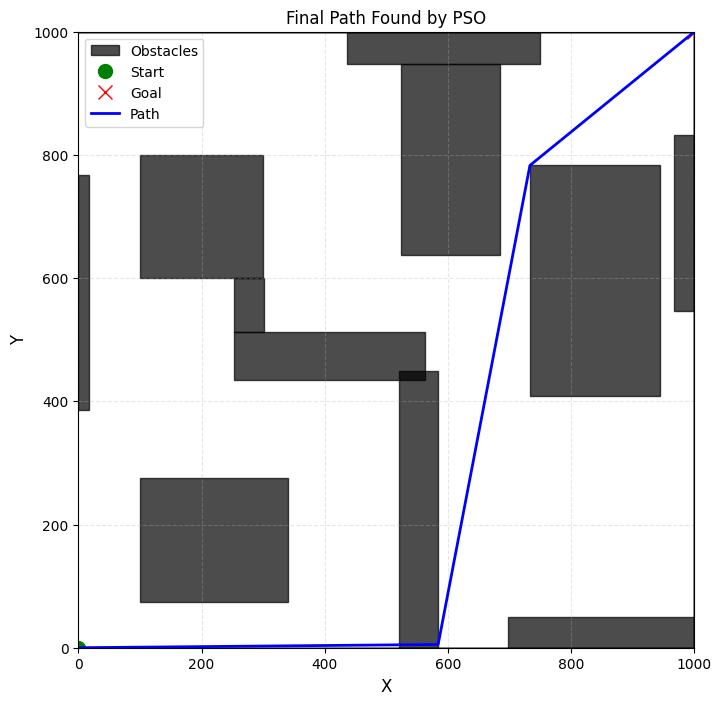

In [217]:
env.plot_environment(path=final_path, title="Final Path Found by PSO")

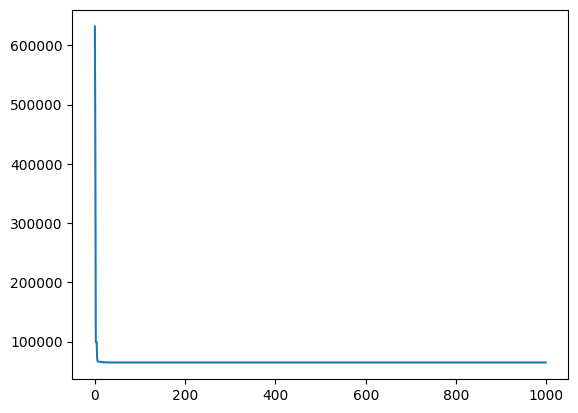

In [218]:
import matplotlib.pyplot as plt

plt.plot(history)